In [ ]:
#!pip install -U efficientnet

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

228827136/228813984 [==============================] - 3s 0us/step
/root/.keras/datasets/flower_photos/roses/5717319579_190e85c7d1_m.jpg


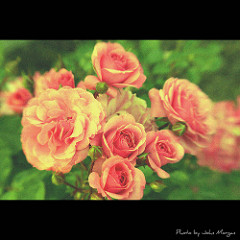

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

roses = list(data_dir.glob('roses/*'))
print(roses[0])
PIL.Image.open(str(roses[0]))

In [ ]:
IMG_SIZE = 224

In [ ]:
img_height,img_width=IMG_SIZE,IMG_SIZE
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = "categorical")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = "categorical")

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [ ]:
num_classes = 5

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs#img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(num_classes)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
epochs=2
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2
92/92 [==============================] - 174s 2s/step - loss: 0.8500 - accuracy: 0.8174 - val_loss: 0.3153 - val_accuracy: 0.9046
Epoch 2/2
92/92 [==============================] - 159s 2s/step - loss: 0.4914 - accuracy: 0.8941 - val_loss: 0.4046 - val_accuracy: 0.8992


In [ ]:
def predict_image(img):
    img_4d=img.reshape(-1,180,180,3)
    prediction=model.predict(img_4d)[0]
    return {class_names[i]: float(prediction[i]) for i in range(5)}